Epoch    0  Loss: 1.1615  Acc: 0.3660


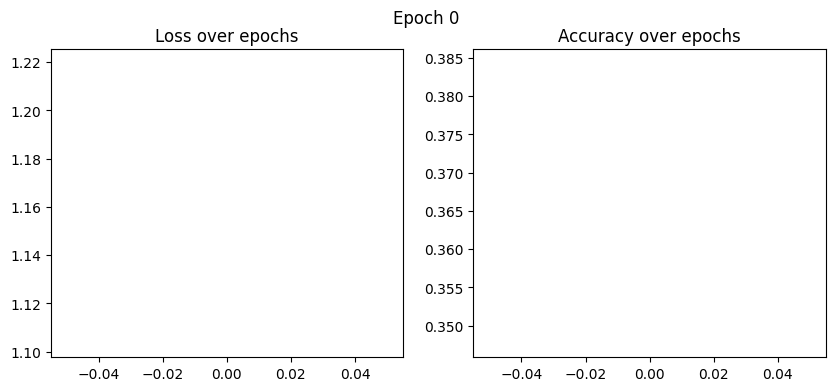

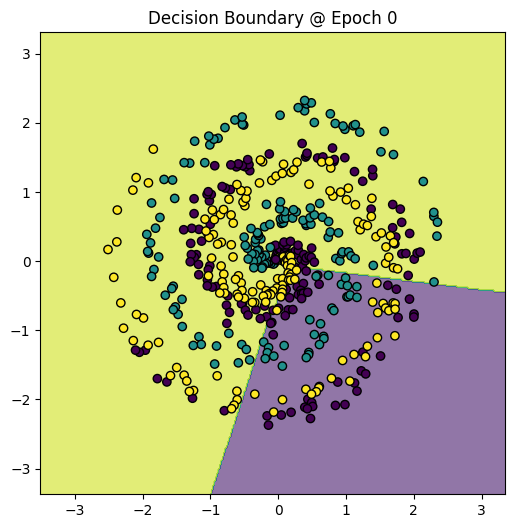

Epoch  250  Loss: 0.1733  Acc: 0.9280


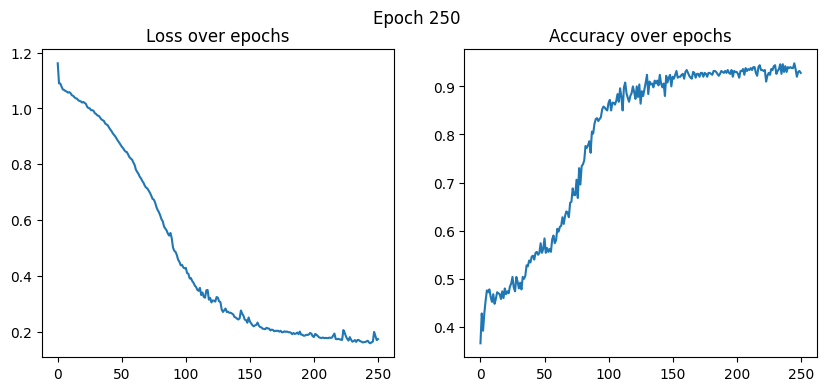

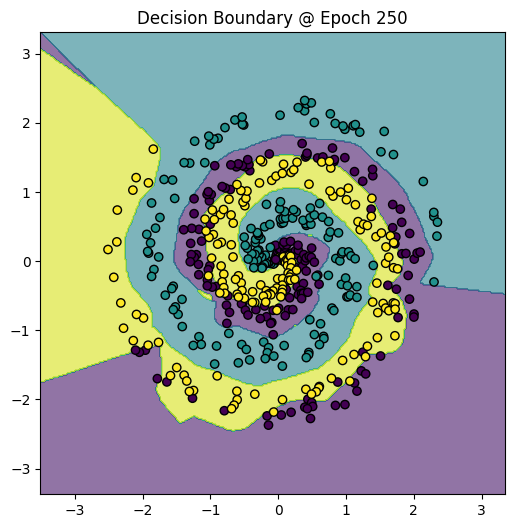

Epoch  500  Loss: 0.1287  Acc: 0.9400


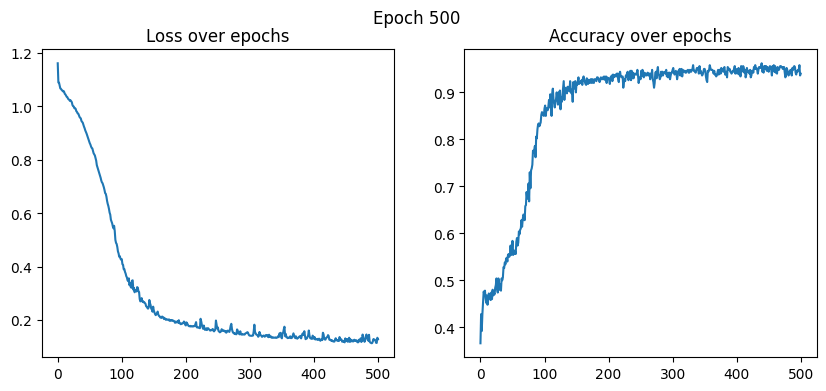

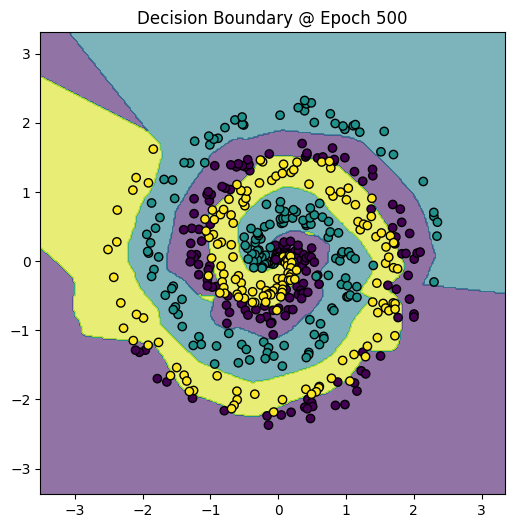

Epoch  750  Loss: 0.1074  Acc: 0.9560


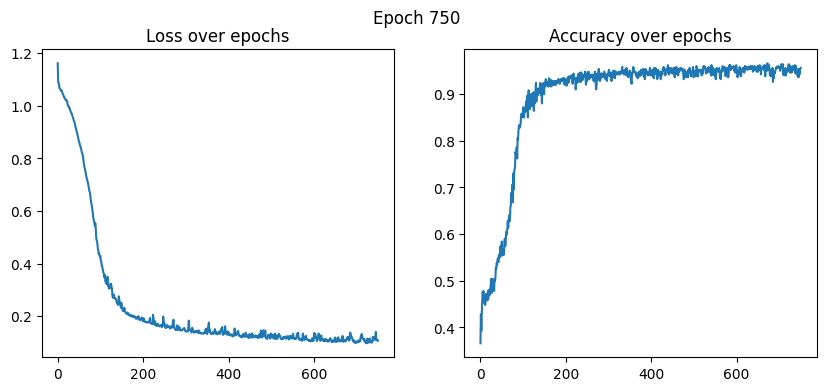

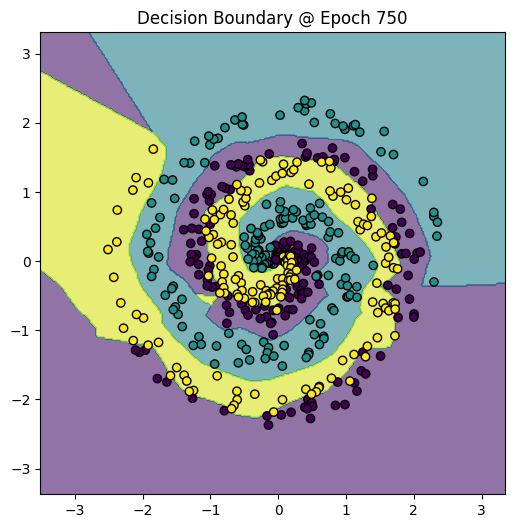

Epoch 1000  Loss: 0.0980  Acc: 0.9580


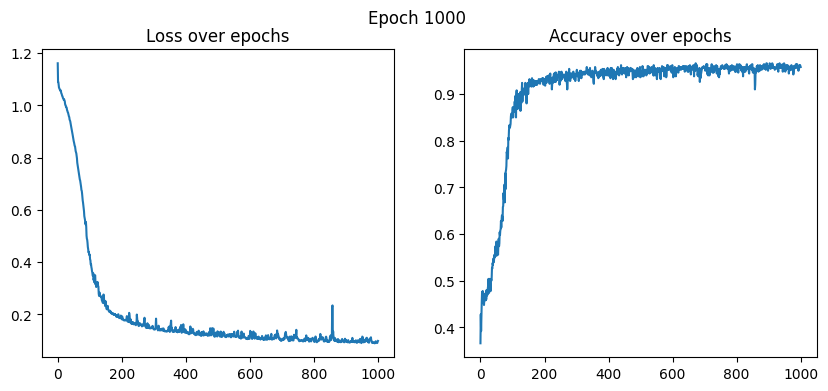

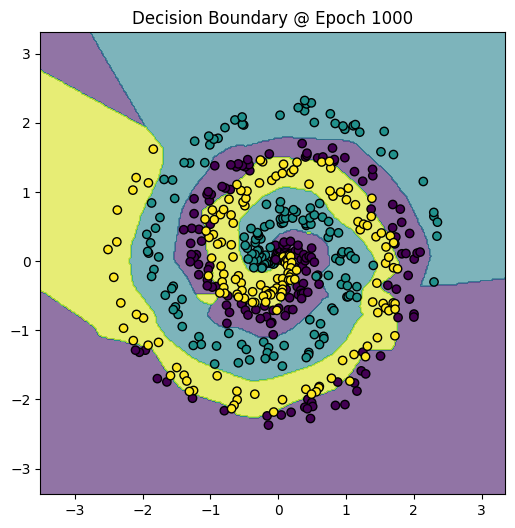

Epoch 1250  Loss: 0.1087  Acc: 0.9500


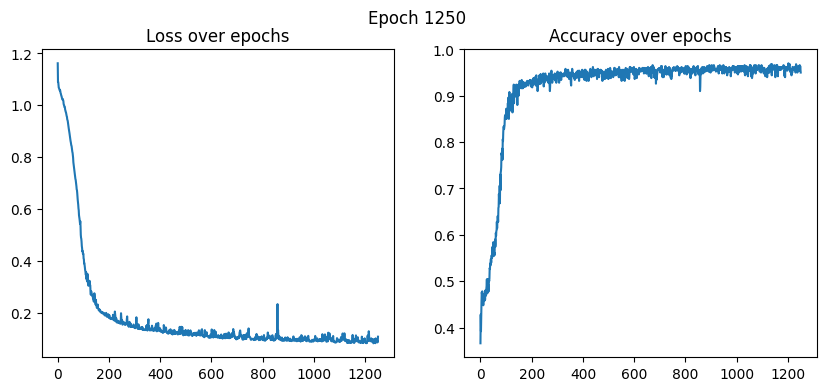

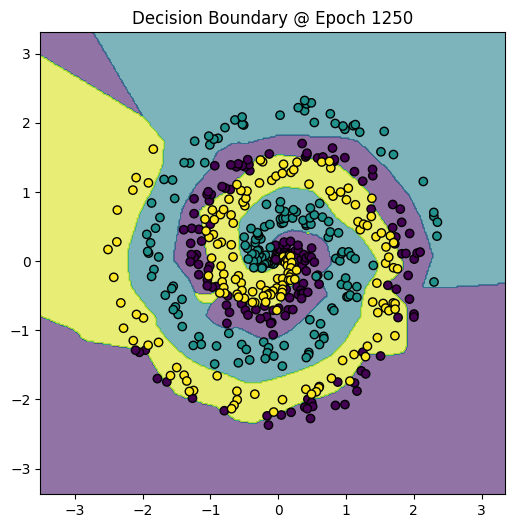

Epoch 1500  Loss: 0.0971  Acc: 0.9500


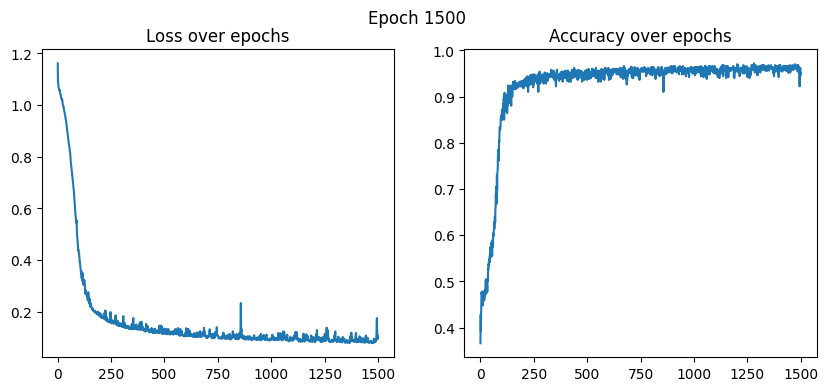

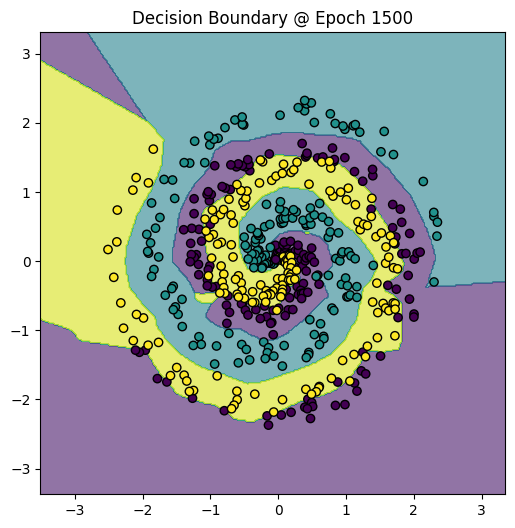

Epoch 1750  Loss: 0.0873  Acc: 0.9620


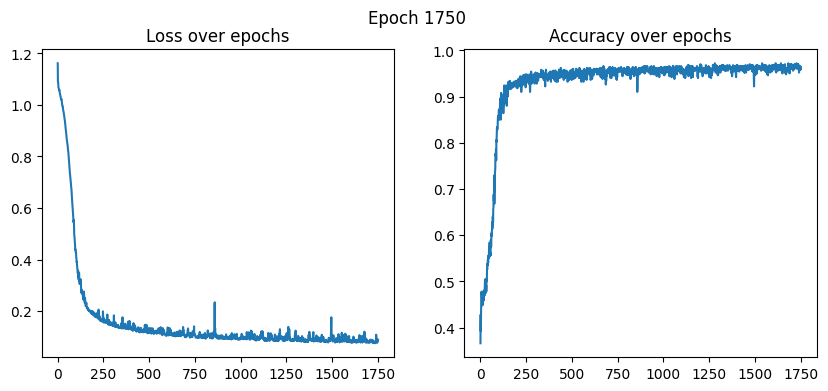

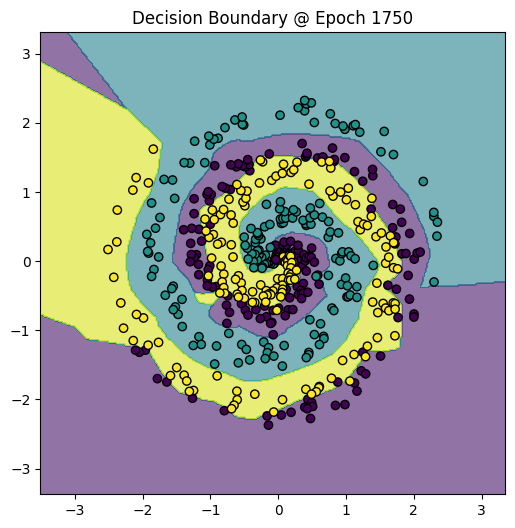

Epoch 2000  Loss: 0.0741  Acc: 0.9680


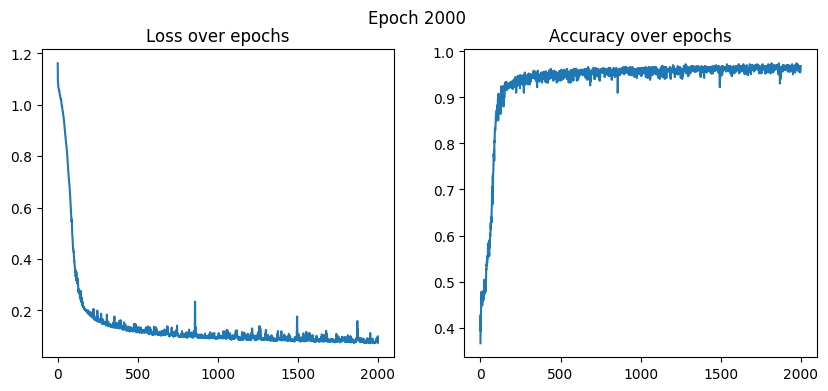

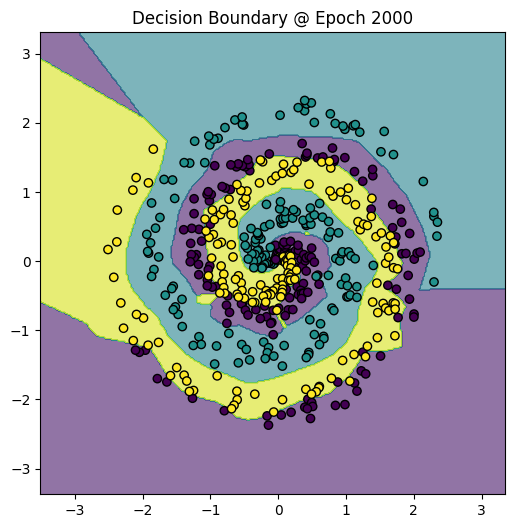

Epoch 2250  Loss: 0.0674  Acc: 0.9700


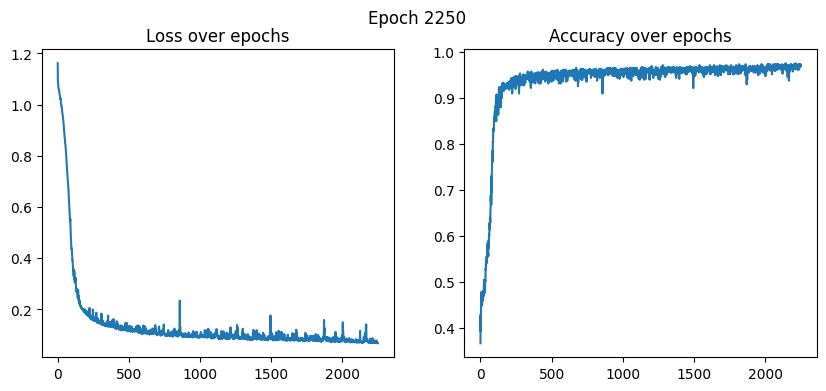

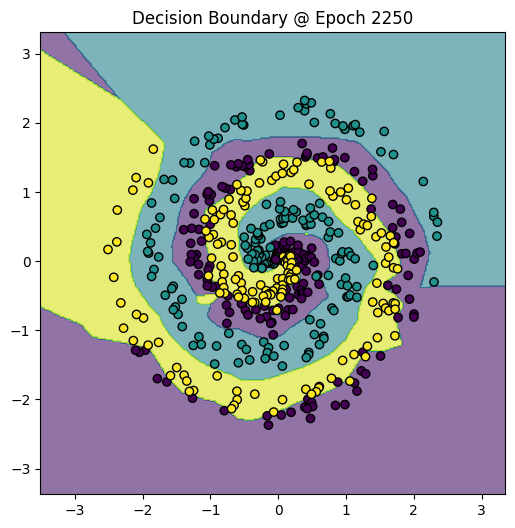

Epoch 2500  Loss: 0.0769  Acc: 0.9640


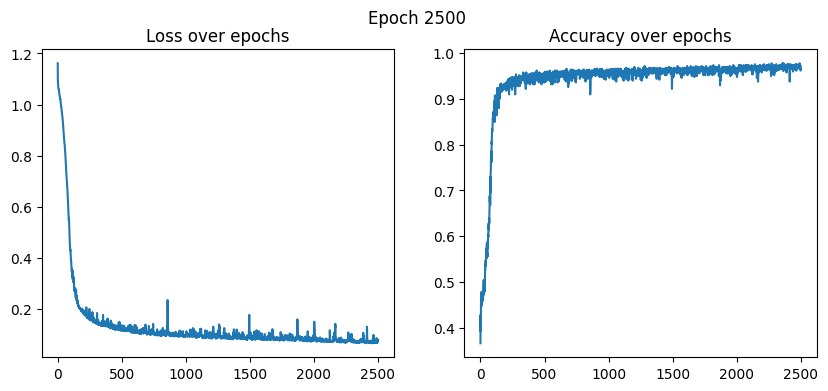

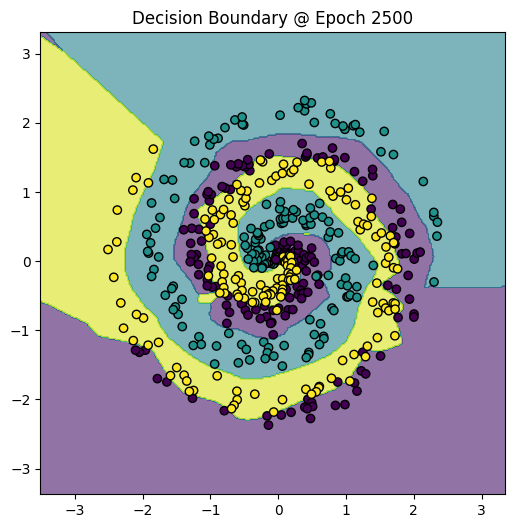

Epoch 2750  Loss: 0.0733  Acc: 0.9700


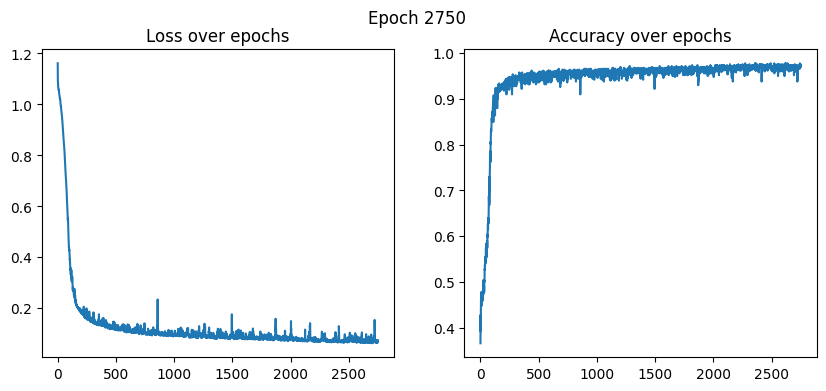

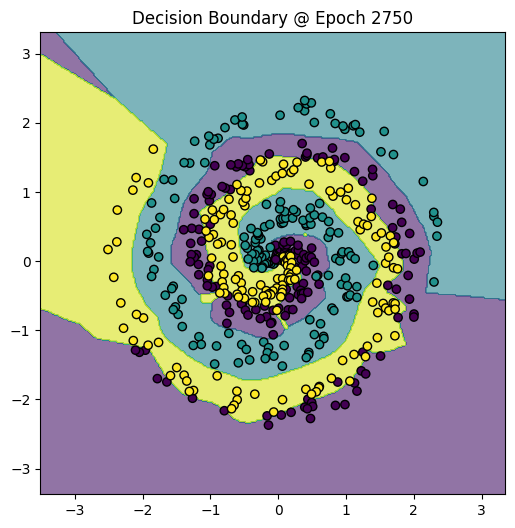

Epoch 3000  Loss: 0.0711  Acc: 0.9680


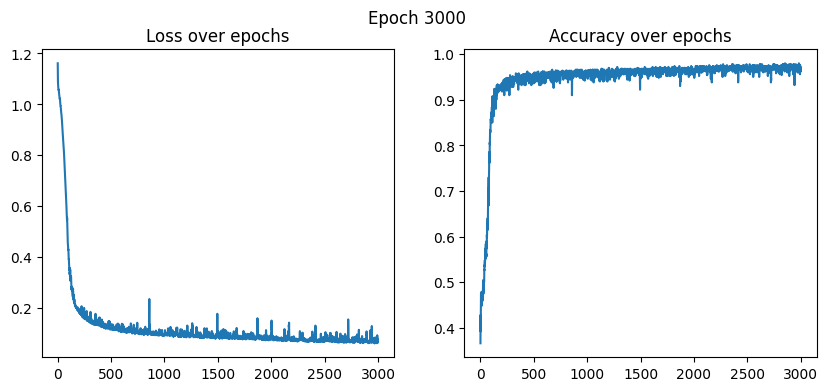

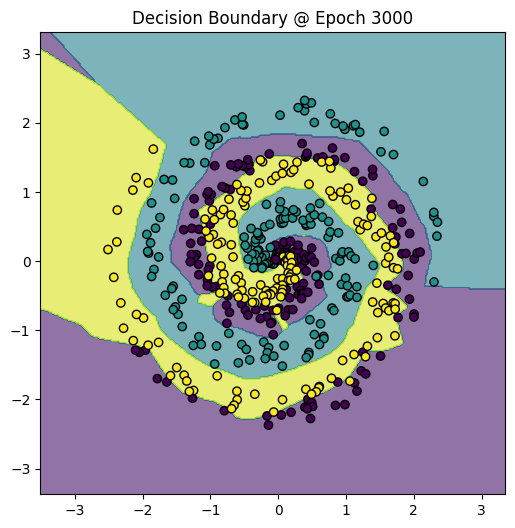

Epoch 3250  Loss: 0.0585  Acc: 0.9780


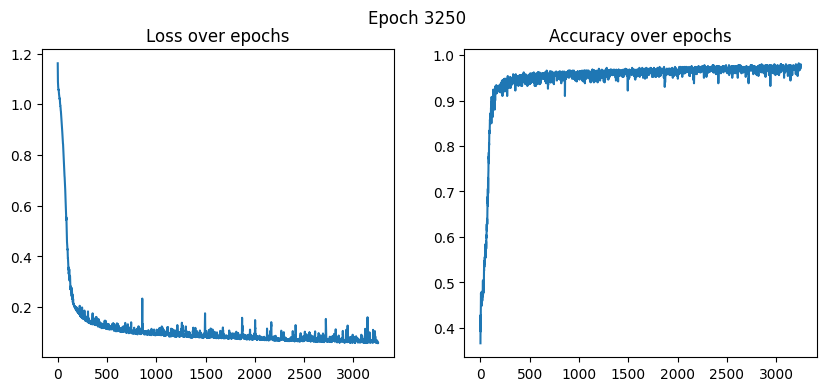

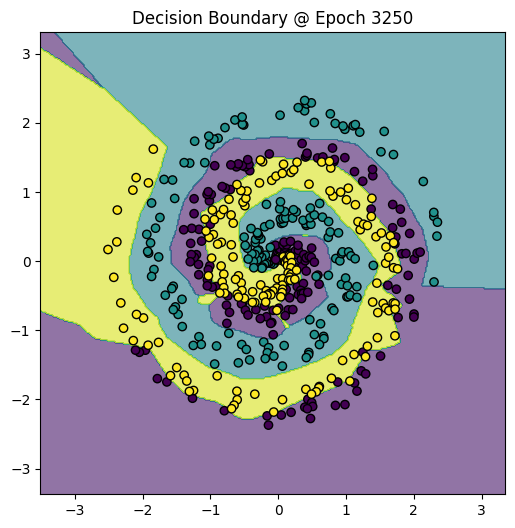

Epoch 3500  Loss: 0.0636  Acc: 0.9800


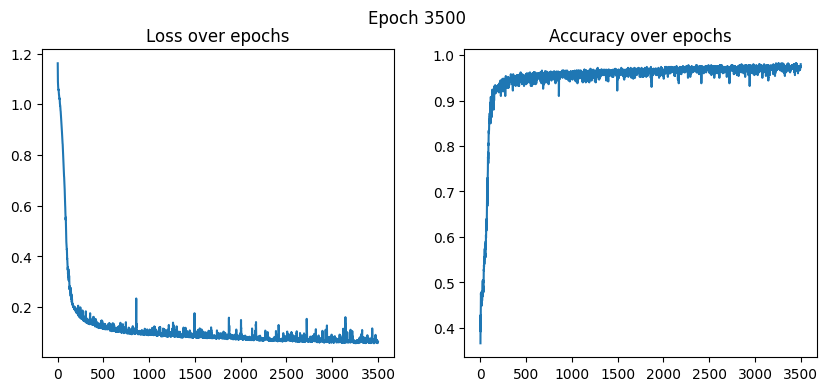

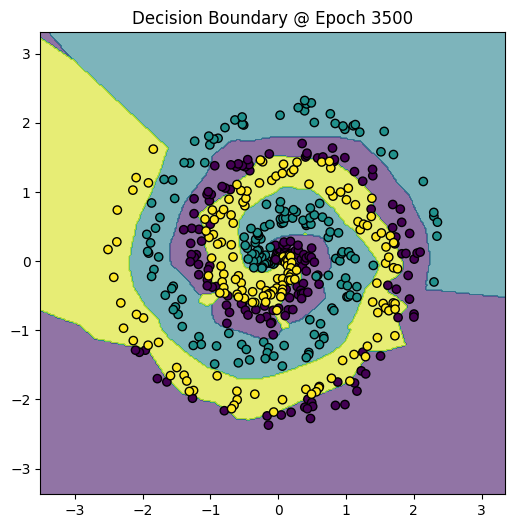

Epoch 3750  Loss: 0.0570  Acc: 0.9800


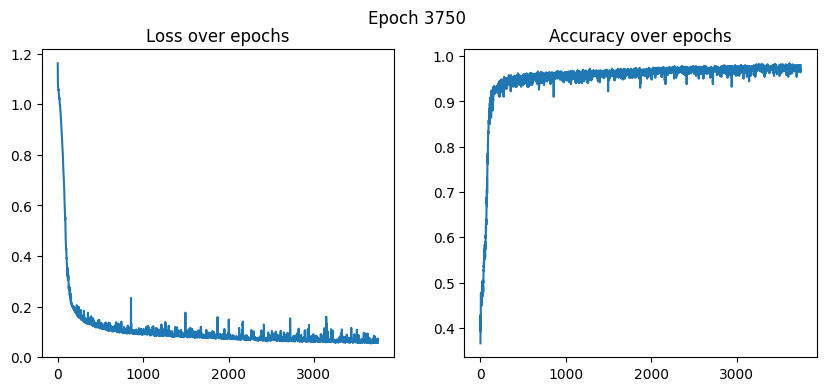

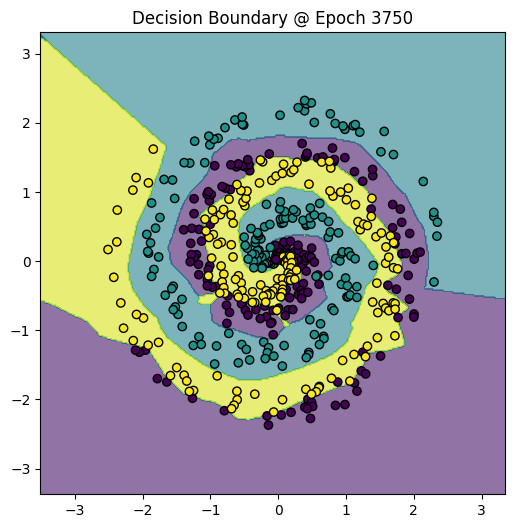

Training complete.


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('/content/data.csv')
X = df[['x1', 'x2']].values
y = df['class'].values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std


num_classes = 3
Y = np.eye(num_classes)[y.astype(int)]

def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)
def softmax(x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

def accuracy(pred_probs, Y_true):
    preds = np.argmax(pred_probs, axis=1)
    return (preds == np.argmax(Y_true, axis=1)).mean()

class NN:
    def __init__(self, input_dim=2, h1=64, h2=32, out=3, seed=0):
        np.random.seed(seed)

        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2. / input_dim)
        self.b1 = np.zeros((1, h1))
        self.W2 = np.random.randn(h1, h2) * np.sqrt(2. / h1)
        self.b2 = np.zeros((1, h2))
        self.W3 = np.random.randn(h2, out) * np.sqrt(2. / h2)
        self.b3 = np.zeros((1, out))


        self.m = {k: np.zeros_like(v) for k,v in self.params().items()}
        self.v = {k: np.zeros_like(v) for k,v in self.params().items()}
        self.beta1, self.beta2, self.eps = 0.9, 0.999, 1e-8
        self.t = 0

    def params(self):
        return {'W1': self.W1, 'b1': self.b1,
                'W2': self.W2, 'b2': self.b2,
                'W3': self.W3, 'b3': self.b3}

    def forward(self, X):
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = relu(self.z2)
        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = softmax(self.z3)
        return self.a3

    def compute_loss(self, pred, Y):
        n = Y.shape[0]
        return -np.sum(Y * np.log(pred + 1e-9)) / n

    def backward(self, X, Y, pred):
        n = X.shape[0]
        grads = {}
        dz3 = (pred - Y) / n
        grads['W3'] = self.a2.T.dot(dz3)
        grads['b3'] = np.sum(dz3, axis=0, keepdims=True)
        da2 = dz3.dot(self.W3.T)
        dz2 = da2 * relu_deriv(self.z2)
        grads['W2'] = self.a1.T.dot(dz2)
        grads['b2'] = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2.dot(self.W2.T)
        dz1 = da1 * relu_deriv(self.z1)
        grads['W1'] = X.T.dot(dz1)
        grads['b1'] = np.sum(dz1, axis=0, keepdims=True)
        return grads

    def step_adam(self, grads, lr, weight_decay=0.0):
        self.t += 1
        for k, g in grads.items():
            if weight_decay != 0 and k.startswith('W'):
                g = g + weight_decay * getattr(self, k)
            self.m[k] = self.beta1 * self.m[k] + (1 - self.beta1) * g
            self.v[k] = self.beta2 * self.v[k] + (1 - self.beta2) * (g * g)
            m_hat = self.m[k] / (1 - self.beta1 ** self.t)
            v_hat = self.v[k] / (1 - self.beta2 ** self.t)
            getattr(self, k)[:] -= lr * m_hat / (np.sqrt(v_hat) + self.eps)

np.random.seed(0)
model = NN(h1=64, h2=32)
lr = 0.005
epochs = 4000
batch_size = 64
weight_decay = 1e-4

losses, accs = [], []
n_samples = X.shape[0]
idxs = np.arange(n_samples)

for ep in range(epochs):
    np.random.shuffle(idxs)
    for start in range(0, n_samples, batch_size):
        batch_idx = idxs[start:start+batch_size]
        XB, YB = X[batch_idx], Y[batch_idx]
        preds = model.forward(XB)
        grads = model.backward(XB, YB, preds)
        model.step_adam(grads, lr, weight_decay)

    preds_all = model.forward(X)
    loss = model.compute_loss(preds_all, Y)
    acc = accuracy(preds_all, Y)
    losses.append(loss)
    accs.append(acc)


    if ep % 250 == 0:
        print(f"Epoch {ep:4d}  Loss: {loss:.4f}  Acc: {acc:.4f}")


        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.plot(losses); plt.title('Loss over epochs')
        plt.subplot(1,2,2); plt.plot(accs); plt.title('Accuracy over epochs')
        plt.suptitle(f"Epoch {ep}")
        plt.show()


        h = 0.02
        x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
        y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = np.argmax(model.forward(grid), axis=1).reshape(xx.shape)
        plt.figure(figsize=(6,6))
        plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.6)
        plt.scatter(X[:,0], X[:,1], c=np.argmax(Y, axis=1), edgecolor='k')
        plt.title(f"Decision Boundary @ Epoch {ep}")
        plt.show()

print("Training complete.")
